<a href="https://colab.research.google.com/github/Erickrus/llm/blob/main/TRL_GRPOTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TRL GRPOTrainer

https://huggingface.co/docs/trl/en/grpo_trainer

Overview
TRL supports the GRPO Trainer for training language models, as described in the paper [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://huggingface.co/papers/2402.03300) by Zhihong Shao, Peiyi Wang, Qihao Zhu, Runxin Xu, Junxiao Song, Mingchuan Zhang, Y. K. Li, Y. Wu, Daya Guo.

The abstract from the paper is the following:

> *Mathematical reasoning poses a significant challenge for language models due to its complex and structured nature. In this paper, we introduce DeepSeekMath 7B, which continues pre-training DeepSeek-Coder-Base-v1.5 7B with 120B math-related tokens sourced from Common Crawl, together with natural language and code data. DeepSeekMath 7B has achieved an impressive score of 51.7% on the competition-level MATH benchmark without relying on external toolkits and voting techniques, approaching the performance level of Gemini-Ultra and GPT-4. Self-consistency over 64 samples from DeepSeekMath 7B achieves 60.9% on MATH. The mathematical reasoning capability of DeepSeekMath is attributed to two key factors: First, we harness the significant potential of publicly available web data through a meticulously engineered data selection pipeline. Second, we introduce Group Relative Policy Optimization (GRPO), a variant of Proximal Policy Optimization (PPO), that enhances mathematical reasoning abilities while concurrently optimizing the memory usage of PPO.*

This post-training method was contributed by [Quentin Gallouédec](https://huggingface.co/qgallouedec).

##TRL GRPO algorithm explained


GRPO is an online learning algorithm, meaning it improves iteratively by using the data generated by the trained model itself during training. The intuition behind GRPO objective is to maximize the advantage of the generated completions, while ensuring that the model remains close to the reference policy. To understand how GRPO works, it can be broken down into four main steps: **Generating completions**, **computing the advantage**, **estimating the KL divergence**, and **computing the loss**.

<img src="https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png" width=800px />

###Generating completions
At each training step, we sample a batch of prompts and generate a set of
$G$ completions for each prompt (denoted as $o_i$).




###Computing the advantage
For each of the $G$ sequences, we compute the reward using a reward model. To align with the comparative nature of reward models—typically trained on datasets of comparisons between outputs for the same question—the advantage is calculated to reflect these relative comparisons. It is normalized as follows:

$$\hat{A}=\frac{r_i-mean(r)}{std(r)}$$

This approach gives the method its name: **Group Relative Policy Optimization (GRPO)**.

###Estimating the KL divergence
KL divergence is estimated using the approximator introduced by [Schulman et al. (2020)](http://joschu.net/blog/kl-approx.html). The approximator is defined as follows:

$$\mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]=\frac{\pi_{ref}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta}(o_{i,t}|q,o_{i,<t})} - log{\frac{\pi_{ref}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}} - 1, $$

###Computing the loss
The objective is to maximize the advantage while ensuring that the model remains close to the reference policy. Consequently, the loss is defined as follows:

$$\mathcal{L}_{GRPO}(\theta)=-\frac{1}{G}\sum^{G}_{i=1}\frac{1}{|o_i|}\sum^{|o_i|}_{t=1}\left[\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{[\pi_{\theta}(o_{i,t}|q,o_{i,<t})]_{no\ grad}}\hat{A}_{i,t}-\beta \mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]\right],$$

where the first term represents the scaled advantage and the second term penalizes deviations from the reference policy through KL divergence.

In the original paper, this formulation is generalized to account for multiple updates after each generation by leveraging the **clipped surrogate objective**:

$$\mathcal{L}_{GRPO}(\theta)=-\frac{1}{G}\sum^{G}_{i=1}\frac{1}{|o_i|}\sum^{|o_i|}_{t=1}\left[min \left(\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta_{old}}(o_{i,t}|q,o_{i,<t})}\hat{A}_{i,t}, clip \left(\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta_{old}}(o_{i,t}|q,o_{i,<t})},1-\epsilon,1+\epsilon \right) \hat{A}_{i,t}\right)-\beta \mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]\right],$$

where $clip(\cdot,1−\epsilon,1+\epsilon)$ ensures that updates do not deviate excessively from the reference policy by bounding the policy ratio between  $1−\epsilon$ and $1+\epsilon$. In TRL though, as in the original paper, we only do one update per generation, so we can simplify the loss to the first form.

###Logged metrics
The GRPO Trainer logs the following metrics:

- `completion_length`: The average completion length.
- `reward/{reward_func_name}`: The reward computed by each reward function.
- `reward`: The average reward.
- `reward_std` : The average standard deviation within reward groups.
- `kl` : The average KL divergence between the model and the reference model calculated on completions.

###Log probability

https://en.wikipedia.org/wiki/Log_probability

Representing probabilities in this way has several practical advantages:

- **Speed**. Since multiplication is more expensive than addition, taking the product of a high number of probabilities is often faster if they are represented in log form. (The conversion to log form is expensive, but is only incurred once.) Multiplication arises from calculating the probability that multiple independent events occur: the probability that all independent events of interest occur is the product of all these events' probabilities.
- **Accuracy**. The use of log probabilities improves numerical stability, when the probabilities are very small, because of the way in which computers approximate real numbers.[1]
- **Simplicity**. Many probability distributions have an exponential form. Taking the log of these distributions eliminates the exponential function, unwrapping the exponent. For example, the log probability of the normal distribution's probability density function is $\displaystyle -((x-m_{x})/\sigma _{m})^{2}+C$ instead of
$\displaystyle C_{2}\exp \left(-((x-m_{x})/\sigma _{m})^{2}\right)$. Log probabilities make some mathematical manipulations easier to perform.
- **Optimization**. Since most common probability distributions—notably the exponential family—are only logarithmically concave,[2][3] and concavity of the objective function plays a key role in the maximization of a function such as probability, optimizers work better with log probabilities.

###Pseudo Code

[DeepSeekMath: Pushing the Limits of Mathematical
Reasoning in Open Language Models](https://arxiv.org/pdf/2402.03300)

**4.1.1. From PPO to GRPO**

page 14

---
**Algorithm 1 Iterative Group Relative Policy Optimization**

---
**Input:** initial policy model $\pi_{\theta_{\text{init}}}$; reward models $r_{\phi}$; task prompts $\mathcal{D}$; hyperparameters $\epsilon$, $\beta$, $\mu$

1: policy model $\pi_{\theta} \leftarrow \pi_{\theta_{\text{init}}}$

2: **for** iteration = 1, $\ldots$, I **do**

3: &nbsp;&nbsp;&nbsp;&nbsp; reference model $\pi_{\text{ref}} \leftarrow \pi_{\theta}$

4: &nbsp;&nbsp;&nbsp;&nbsp; **for** step = 1, $\ldots$, M **do**

5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample a batch $\mathcal{D}_b$ from $\mathcal{D}$

6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update the old policy model $\pi_{\theta_{\text{old}}} \leftarrow \pi_{\theta}$

7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Sample](#sample_output) $G$ outputs $\{o_i\}_{i=1}^{G} \sim \pi_{\theta_{\text{old}}}(\cdot \mid q)$ for each question $q \in \mathcal{D}_b$

8: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Compute rewards](#reward) $\{r_i\}_{i=1}^{G}$ for each sampled output $o_i$ by running $r_{\phi}$

9: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $\hat{A}_{i,t}$ for the $t$-th token of $o_i$ through [group relative advantage estimation](#groupwise_advantage_calculation).

10: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **for** GRPO iteration = 1, $\ldots$, $\mu$ **do**

11: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update the policy model $\pi_{\theta}$ by [maximizing the GRPO objective](#grpo_loss) (Equation 21)

12: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update $r_{\phi}$ through continuous training using a replay mechanism.

**Output:** $\pi_{\theta}$

---

$GC_{GRPO}(q, o, t, \pi_{\theta_{r m}}) = \hat{A}_{i, t} + \beta \left( \frac{\pi_{\text{ref}}(o_{i, t} \mid o_{i, < t})}{\pi_{\theta}(o_{i, t} \mid o_{i, < t})} - 1 \right),$ (21)



The above pseudo algorithm description does not necessarily align with huggingface's trl implementation.

line 3, each iteration the model is changing a little bit, $\pi_{\text{ref}} \leftarrow \pi_{\theta}$

line 6, in each step, the policy model will change $\pi_{\theta_{\text{old}}} \leftarrow \pi_{\theta}$.

- current model $\pi_{\theta}$
- old model $\pi_{\theta_{\text{old}}}$, $- 1 step$ behind the current model
- ref model $\pi_{\text{ref}}$, $- M steps$ behind the current model

line 7: sample $G$ output


##TRL GRPO code explained

In [ ]:
#@title Mermaid Ink
#https://github.com/jihchi/mermaid.ink

import base64
import io
import requests
import IPython
import re
from PIL import Image
from io import BytesIO

def mermaid(graph, format='svg', scale=0.5):

    format = format.lower().strip()
    if format == 'svg':
        mermaidInkUrl = 'https://mermaid.ink/svg/'
        svg_content = requests.get(
            mermaidInkUrl + base64.b64encode(graph.encode('ascii')).decode("ascii")
        ).content.decode('utf-8')
        svg_content = re.sub(r'(<svg[^>]*>)', r'\1<g transform="scale({})">'.format(scale), svg_content, 1)
        svg_content = svg_content.replace('</svg>', '</g></svg>')

        display(IPython.display.HTML(svg_content))
    else:
        mermaidInkUrl = 'https://mermaid.ink/img/'

        response = requests.get(
            mermaidInkUrl + base64.b64encode(graph.encode('ascii')).decode("ascii")
        )
        image = Image.open(BytesIO(response.content))
        display(image.resize((int(image.width * scale), int(image.height * scale)), Image.BICUBIC))


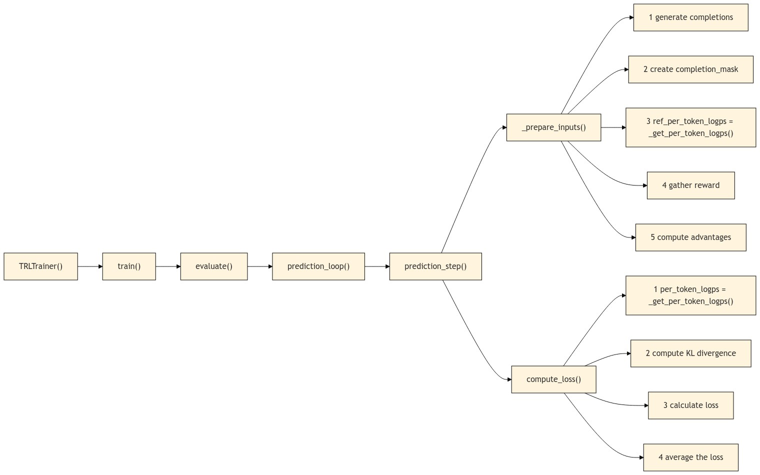

In [ ]:
#@title Calling graph

#@markdown
mermaid("""
  %%{init: {'theme': 'base', 'themeVariables': { 'transparent': '#F0F0F0', 'primaryBorderColor':'#000000'}}}%%
  graph LR;
  TRLTrainer["TRLTrainer()"] --> train["train()"]
  train --> evaluate["evaluate()"]
  evaluate --> prediction_loop["prediction_loop()"]
  prediction_loop --> prediction_step["prediction_step()"]
  prediction_step --> _prepare_inputs["_prepare_inputs()"]
  _prepare_inputs --> generate_completions["1 generate completions"]
  _prepare_inputs --> completion_mask["2 create completion_mask"]
  _prepare_inputs --> _get_per_token_logps1["3 ref_per_token_logps = _get_per_token_logps()"]
  _prepare_inputs --> gather_reward["4 gather reward"]
  _prepare_inputs --> compute_advantages["5 compute advantages"]

  prediction_step --> compute_loss["compute_loss()"]
  compute_loss --> _get_per_token_logps3["1 per_token_logps = _get_per_token_logps()"]
  compute_loss --> compute_KL_divergence["2 compute KL divergence"]
  compute_loss --> calculate_loss["3 calculate loss"]
  compute_loss --> average_loss["4 average the loss"]

""", format='png')

```python
# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

```python
import os
import textwrap
import warnings
from collections import defaultdict
from typing import Any, Callable, Optional, Sized, Union
from unittest.mock import patch

import torch
import torch.utils.data
import transformers
from accelerate.utils import broadcast_object_list, gather, gather_object
from accelerate.utils.other import is_compiled_module
from datasets import Dataset, IterableDataset
from packaging import version
from torch import nn
from torch.utils.data import Sampler
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GenerationConfig,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    Trainer,
    TrainerCallback,
    is_wandb_available,
)
from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.utils import is_peft_available

from ..data_utils import apply_chat_template, is_conversational, maybe_apply_chat_template
from ..import_utils import is_vllm_available
from ..models import create_reference_model, prepare_deepspeed, unwrap_model_for_generation
from .callbacks import SyncRefModelCallback
from .grpo_config import GRPOConfig
from .utils import generate_model_card, get_comet_experiment_url, pad, selective_log_softmax

```

```python
if is_peft_available():
    from peft import PeftConfig, get_peft_model

if is_vllm_available():
    from vllm import LLM, SamplingParams

if is_wandb_available():
    import wandb

# What we call a reward function is a callable that takes a list of prompts and completions and returns a list of
# rewards. When it's a string, it's a model ID, so it's loaded as a pretrained model.
RewardFunc = Union[str, PreTrainedModel, Callable[[list, list], list[float]]]
```

```python
class RepeatRandomSampler(Sampler):
    """
    Sampler that repeats the indices of a dataset N times.

    Args:
        data_source (`Sized`):
            Dataset to sample from.
        repeat_count (`int`):
            Number of times to repeat each index.

    Example:
    ```python
    >>> sampler = RepeatRandomSampler(["a", "b", "c", "d"], repeat_count=2)
    >>> list(sampler)
    [2, 2, 0, 0, 3, 3, 1, 1]
    ```
    """

    def __init__(self, data_source: Sized, repeat_count: int):
        self.data_source = data_source
        self.repeat_count = repeat_count
        self.num_samples = len(data_source)

    def __iter__(self):
        indexes = [idx for idx in torch.randperm(self.num_samples).tolist() for _ in range(self.repeat_count)]
        return iter(indexes)

    def __len__(self):
        return self.num_samples * self.repeat_count

```

```python
class GRPOTrainer(Trainer):
    """
    Trainer for the Group Relative Policy Optimization (GRPO) method. This algorithm was initially proposed in the
    paper [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://huggingface.co/papers/2402.03300).

    Example:

    ```python
    from datasets import load_dataset
    from trl import GRPOTrainer

    dataset = load_dataset("trl-lib/tldr", split="train")

    trainer = GRPOTrainer(
        model="Qwen/Qwen2-0.5B-Instruct",
        reward_funcs="weqweasdas/RM-Gemma-2B",
        train_dataset=dataset,
    )

    trainer.train()
    ```

    Args:
        model (`Union[str, PreTrainedModel]`):
            Model to be trained. Can be either:

            - A string, being the *model id* of a pretrained model hosted inside a model repo on huggingface.co, or
              a path to a *directory* containing model weights saved using
              [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is
              loaded using [`~transformers.AutoModelForCausalLM.from_pretrained`] with the keywork arguments
              in `args.model_init_kwargs`.
            - A [`~transformers.PreTrainedModel`] object. Only causal language models are supported.
        reward_funcs (`Union[RewardFunc, list[RewardFunc]]`):
            Reward functions to be used for computing the rewards. To compute the rewards, we call all the reward
            functions with the prompts and completions and sum the rewards. Can be either:

            - A single reward function, such as:
                - A string: The *model ID* of a pretrained model hosted inside a model repo on huggingface.co, or a
                path to a *directory* containing model weights saved using
                [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is loaded
                using [`~transformers.AutoModelForSequenceClassification.from_pretrained`] with `num_labels=1` and the
                keyword arguments in `args.model_init_kwargs`.
                - A [`~transformers.PreTrainedModel`] object: Only sequence classification models are supported.
                - A custom reward function: The function is provided with the prompts and the generated completions,
                  plus any additional columns in the dataset. It should return a list of rewards. For more details, see
                  [Using a custom reward function](#using-a-custom-reward-function).
            - A list of reward functions, where each item can independently be any of the above types. Mixing different
            types within the list (e.g., a string model ID and a custom reward function) is allowed.
        args ([`GRPOConfig`], *optional*, defaults to `None`):
            Configuration for this trainer. If `None`, a default configuration is used.
        train_dataset ([`~datasets.Dataset`] or [`~datasets.IterableDataset`]):
            Dataset to use for training. It must include a column `"prompt"`. Any additional columns in the dataset is
            ignored. The format of the samples can be either:

            - [Standard](dataset_formats#standard): Each sample contains plain text.
            - [Conversational](dataset_formats#conversational): Each sample contains structured messages (e.g., role
              and content).
        eval_dataset ([`~datasets.Dataset`], [`~datasets.IterableDataset`] or `dict[str, Union[Dataset, IterableDataset]]`):
            Dataset to use for evaluation. It must meet the same requirements as `train_dataset`.
        processing_class ([`~transformers.PreTrainedTokenizerBase`], *optional*, defaults to `None`):
            Processing class used to process the data. The padding side must be set to "left". If `None`, the
            processing class is loaded from the model's name with [`~transformers.AutoTokenizer.from_pretrained`].
        reward_processing_classes (`Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]`, *optional*, defaults to `None`):
            Processing classes corresponding to the reward functions specified in `reward_funcs`. Can be either:

            - A single processing class: Used when `reward_funcs` contains only one reward function.
            - A list of processing classes: Must match the order and length of the reward functions in `reward_funcs`.
            If set to `None`, or if an element of the list corresponding to a [`~transformers.PreTrainedModel`] is
            `None`, the tokenizer for the model is automatically loaded using [`~transformers.AutoTokenizer.from_pretrained`].
            For elements in `reward_funcs` that are custom reward functions (not [`~transformers.PreTrainedModel`]),
            the corresponding entries in `reward_processing_classes` are ignored.
        callbacks (list of [`~transformers.TrainerCallback`], *optional*, defaults to `None`):
            List of callbacks to customize the training loop. Will add those to the list of default callbacks
            detailed in [here](https://huggingface.co/docs/transformers/main_classes/callback).

            If you want to remove one of the default callbacks used, use the [`~transformers.Trainer.remove_callback`]
            method.
        optimizers (`tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]`, *optional*, defaults to `(None, None)`):
            A tuple containing the optimizer and the scheduler to use. Will default to an instance of [`AdamW`] on your
            model and a scheduler given by [`get_linear_schedule_with_warmup`] controlled by `args`.
        peft_config ([`~peft.PeftConfig`], *optional*, defaults to `None`):
            PEFT configuration used to wrap the model. If `None`, the model is not wrapped.
    """
```

```python
   _tag_names = ["trl", "grpo"]

    def __init__(
        self,
        model: Union[str, PreTrainedModel],
        reward_funcs: Union[RewardFunc, list[RewardFunc]],
        args: GRPOConfig = None,
        train_dataset: Optional[Union[Dataset, IterableDataset]] = None,
        eval_dataset: Optional[Union[Dataset, IterableDataset, dict[str, Union[Dataset, IterableDataset]]]] = None,
        processing_class: Optional[PreTrainedTokenizerBase] = None,
        reward_processing_classes: Optional[Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]] = None,
        callbacks: Optional[list[TrainerCallback]] = None,
        optimizers: tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        peft_config: Optional["PeftConfig"] = None,
    ):
        # Args
        if args is None:
            model_name = model if isinstance(model, str) else model.config._name_or_path
            model_name = model_name.split("/")[-1]
            args = GRPOConfig(f"{model_name}-GRPO")

        # Models
        # Trained model
        model_init_kwargs = args.model_init_kwargs or {}
        if isinstance(model, str):
            model_id = model
            torch_dtype = model_init_kwargs.get("torch_dtype")
            if isinstance(torch_dtype, torch.dtype) or torch_dtype == "auto" or torch_dtype is None:
                pass  # torch_dtype is already a torch.dtype or "auto" or None
            elif isinstance(torch_dtype, str):  # it's a str, but not "auto"
                torch_dtype = getattr(torch, torch_dtype)
                model_init_kwargs["torch_dtype"] = torch_dtype
            else:
                raise ValueError(
                    "Invalid `torch_dtype` passed to `GRPOConfig`. Expected either 'auto' or a string representing "
                    f"a `torch.dtype` (e.g., 'float32'), but got {torch_dtype}."
                )
            # Disable caching if gradient checkpointing is enabled (not supported)
            model_init_kwargs["use_cache"] = (
                False if args.gradient_checkpointing else model_init_kwargs.get("use_cache")
            )
            model = AutoModelForCausalLM.from_pretrained(model, **model_init_kwargs)
        else:
            model_id = model.config._name_or_path
            if args.model_init_kwargs is not None:
                raise ValueError(
                    "You passed `model_init_kwargs` to the `GRPOConfig`, but your model is already instantiated. "
                    "This argument can only be used when the `model` argument is a string."
                )

        if peft_config is not None:
            model = get_peft_model(model, peft_config)

        # Reference model
        if is_deepspeed_zero3_enabled():
            self.ref_model = AutoModelForCausalLM.from_pretrained(model_id, **model_init_kwargs)
        elif peft_config is None:
            # If PEFT configuration is not provided, create a reference model based on the initial model.
            self.ref_model = create_reference_model(model)
        else:
            # If PEFT is used, the reference model is not needed since the adapter can be disabled
            # to revert to the initial model.
            self.ref_model = None

        # Processing class
        if processing_class is None:
            processing_class = AutoTokenizer.from_pretrained(model.config._name_or_path, padding_side="left")

        # Reward functions
        if not isinstance(reward_funcs, list):
            reward_funcs = [reward_funcs]
        for i, reward_func in enumerate(reward_funcs):
            if isinstance(reward_func, str):
                reward_funcs[i] = AutoModelForSequenceClassification.from_pretrained(
                    reward_func, num_labels=1, **model_init_kwargs
                )
        self.reward_funcs = reward_funcs

        # Reward processing class
        if reward_processing_classes is None:
            reward_processing_classes = [None] * len(reward_funcs)
        elif not isinstance(reward_processing_classes, list):
            reward_processing_classes = [reward_processing_classes]
        else:
            if len(reward_processing_classes) != len(reward_funcs):
                raise ValueError("The number of reward processing classes must match the number of reward functions.")

        for i, (reward_processing_class, reward_func) in enumerate(zip(reward_processing_classes, reward_funcs)):
            if isinstance(reward_func, PreTrainedModel):
                if reward_processing_class is None:
                    reward_processing_class = AutoTokenizer.from_pretrained(reward_func.config._name_or_path)
                if reward_processing_class.pad_token_id is None:
                    reward_processing_class.pad_token = reward_processing_class.eos_token
                # The reward model computes the reward for the latest non-padded token in the input sequence.
                # So it's important to set the pad token ID to the padding token ID of the processing class.
                reward_func.config.pad_token_id = reward_processing_class.pad_token_id
                reward_processing_classes[i] = reward_processing_class
        self.reward_processing_classes = reward_processing_classes

        # Data collator
        def data_collator(features):  # No data collation is needed in GRPO
            return features

        # Training arguments
        self.max_prompt_length = args.max_prompt_length
        self.max_completion_length = args.max_completion_length  # = |o_i| in the GRPO paper
        self.num_generations = args.num_generations  # = G in the GRPO paper
        self.use_vllm = args.use_vllm

        self.beta = args.beta

        # The trainer estimates the number of FLOPs (floating-point operations) using the number of elements in the
        # input tensor associated with the key "input_ids". However, in GRPO, the sampled data does not include the
        # "input_ids" key. Instead, the available keys is "prompt". As a result, the trainer issues the warning:
        # "Could not estimate the number of tokens of the input, floating-point operations will not be computed." To
        # suppress this warning, we set the "estimate_tokens" key in the model's "warnings_issued" dictionary to True.
        # This acts as a flag to indicate that the warning has already been issued.
        model.warnings_issued["estimate_tokens"] = True

        # Initialize the metrics
        self._metrics = defaultdict(list)
        self.log_completions = args.log_completions

        super().__init__(
            model=model,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=processing_class,
            callbacks=callbacks,
            optimizers=optimizers,
        )

        # Check if the per_device_train/eval_batch_size * num processes can be divided by the number of generations
        num_processes = self.accelerator.num_processes
        global_batch_size = args.per_device_train_batch_size * num_processes
        possible_values = [n_gen for n_gen in range(2, global_batch_size + 1) if (global_batch_size) % n_gen == 0]
        if self.num_generations not in possible_values:
            raise ValueError(
                f"The global train batch size ({num_processes} x {args.per_device_train_batch_size}) must be evenly "
                f"divisible by the number of generations per prompt ({self.num_generations}). Given the current train "
                f"batch size, the valid values for the number of generations are: {possible_values}."
            )
        if self.args.eval_strategy != "no":
            global_batch_size = args.per_device_eval_batch_size * num_processes
            possible_values = [n_gen for n_gen in range(2, global_batch_size + 1) if (global_batch_size) % n_gen == 0]
            if self.num_generations not in possible_values:
                raise ValueError(
                    f"The global eval batch size ({num_processes} x {args.per_device_eval_batch_size}) must be evenly "
                    f"divisible by the number of generations per prompt ({self.num_generations}). Given the current "
                    f"eval batch size, the valid values for the number of generations are: {possible_values}."
                )

        if self.use_vllm:
            if not is_vllm_available():
                raise ImportError(
                    "vLLM is not available and `use_vllm` is set to True. Please install vLLM with "
                    "`pip install vllm` to use it."
                )

            if self.accelerator.is_main_process:
                vllm_device = self.args.vllm_device
                if vllm_device == "auto":
                    vllm_device = f"cuda:{self.accelerator.num_processes}"  # take the next GPU idx
                # Check that the requested device is available
                if vllm_device.split(":")[0] == "cuda" and int(vllm_device.split(":")[1]) >= torch.cuda.device_count():
                    raise ValueError(
                        f"The requested device for vllm ({vllm_device}) is not available. You are likely using vLLM "
                        "without restricting the number of GPUs for training. Set the `--num_processes` argument to a "
                        "value lower than the number of GPUs available on your machine—typically, reducing it by one "
                        f"is sufficient. In your case: `--num_processes {torch.cuda.device_count() - 1}`."
                    )
                # Check that the requested device is not also used for training
                if vllm_device in {f"cuda:{idx}" for idx in range(self.accelerator.num_processes)}:
                    warnings.warn(
                        f"The requested device {vllm_device} is also used for training. This may lead to unexpected "
                        "behavior. It is recommended to use a dedicated device for vLLM."
                    )
                # vLLM is not compatible with accelerate. So we need to patch it to make sure we can (1) place the vLLM
                # model on the desired device (world_size_patch) and (2) avoid a test that is not designed for our
                # setting (profiling_patch).
                world_size_patch = patch("torch.distributed.get_world_size", return_value=1)
                profiling_patch = patch(
                    "vllm.worker.worker.Worker._assert_memory_footprint_increased_during_profiling", return_value=None
                )
                with world_size_patch, profiling_patch:
                    self.llm = LLM(
                        model=model.name_or_path,
                        device=vllm_device,
                        gpu_memory_utilization=self.args.vllm_gpu_memory_utilization,
                        dtype=self.args.vllm_dtype,
                        # Automatic Prefix Caching caches the KV cache of existing queries, so that a new query can
                        # directly reuse the KV cache if it shares the same prefix with one of the existing queries.
                        # This is particularly useful here because we generate completions from the same prompts.
                        enable_prefix_caching=True,
                        max_model_len=self.args.vllm_max_model_len,
                    )
                self.sampling_params = SamplingParams(
                    temperature=args.temperature,
                    max_tokens=self.max_completion_length,
                )

            self._last_loaded_step = 0  # tag to avoid useless loading during grad accumulation

            # When using vLLM, the main process is responsible for loading the model weights. This can cause process
            # desynchronization and seems to lead to DeepSpeed hanging during initialization. To prevent this, we
            # synchronize all processes after vLLM has been fully initialized.
            self.accelerator.wait_for_everyone()
        else:
            self.generation_config = GenerationConfig(
                max_new_tokens=self.max_completion_length,
                do_sample=True,
                temperature=args.temperature,
                pad_token_id=processing_class.pad_token_id,
            )

        # Gradient accumulation requires scaled loss. Normally, loss scaling in the parent class depends on whether the
        # model accepts loss-related kwargs. Since we compute our own loss, this check is irrelevant. We set
        # self.model_accepts_loss_kwargs to False to enable scaling.
        self.model_accepts_loss_kwargs = False

        # Add tags to the model
        self.model.add_model_tags(self._tag_names)

        if self.ref_model is not None:
            if self.is_deepspeed_enabled:
                self.ref_model = prepare_deepspeed(self.ref_model, self.accelerator)
            else:
                self.ref_model = self.accelerator.prepare_model(self.ref_model, evaluation_mode=True)

        if args.sync_ref_model:
            self.add_callback(SyncRefModelCallback(ref_model=self.ref_model, accelerator=self.accelerator))

        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, PreTrainedModel):
                self.reward_funcs[i] = self.accelerator.prepare_model(reward_func, evaluation_mode=True)

```

```python
    def _set_signature_columns_if_needed(self):
        # If `self.args.remove_unused_columns` is True, non-signature columns are removed.
        # By default, this method sets `self._signature_columns` to the model's expected inputs.
        # In GRPOTrainer, we preprocess data, so using the model's signature columns doesn't work.
        # Instead, we set them to the columns expected by the `training_step` method, hence the override.
        if self._signature_columns is None:
            self._signature_columns = ["prompt"]

  ```

```python
    # We need a custom sampler that samples the same prompt multiple times
    def _get_train_sampler(self) -> Sampler:
        return RepeatRandomSampler(self.train_dataset, self.num_generations)
```

```python
    def _get_eval_sampler(self, eval_dataset) -> Sampler:
        return RepeatRandomSampler(eval_dataset, self.num_generations)
```

```python
    # Get the per-token log probabilities for the completions for the model and the reference model
    def _get_per_token_logps(self, model, input_ids, attention_mask, logits_to_keep):
        # We add 1 to `logits_to_keep` because the last logits of the sequence is later excluded
        logits = model(input_ids=input_ids, attention_mask=attention_mask, logits_to_keep=logits_to_keep + 1).logits
        logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred

        input_ids = input_ids[:, -logits_to_keep:]
        # For transformers<=4.48, logits_to_keep argument isn't supported, so here we drop logits ourselves.
        # See https://github.com/huggingface/trl/issues/2770
        logits = logits[:, -logits_to_keep:]
        return selective_log_softmax(logits, input_ids)  #  compute logprobs for the input tokens
```

```python
    def _move_model_to_vllm(self):
        with unwrap_model_for_generation(
            self.model, self.accelerator, gather_deepspeed3_params=self.args.ds3_gather_for_generation
        ) as unwrapped_model:
            if is_compiled_module(unwrapped_model):
                state_dict = unwrapped_model._orig_mod.state_dict()
            else:
                state_dict = unwrapped_model.state_dict()
        if self.accelerator.is_main_process:
            llm_model = self.llm.llm_engine.model_executor.driver_worker.model_runner.model
            llm_model.load_weights(state_dict.items())
```

```python
    def _prepare_inputs(self, inputs: dict[str, Union[torch.Tensor, Any]]) -> dict[str, Union[torch.Tensor, Any]]:
        device = self.accelerator.device
        prompts = [x["prompt"] for x in inputs]
        prompts_text = [maybe_apply_chat_template(example, self.processing_class)["prompt"] for example in inputs]
        prompt_inputs = self.processing_class(
            prompts_text, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False
        )
        prompt_inputs = super()._prepare_inputs(prompt_inputs)
        prompt_ids, prompt_mask = prompt_inputs["input_ids"], prompt_inputs["attention_mask"]

        if self.max_prompt_length is not None:
            prompt_ids = prompt_ids[:, -self.max_prompt_length :]
            prompt_mask = prompt_mask[:, -self.max_prompt_length :]

```
Generate completions
<a name="sample_output"></a>
```python
        # Generate completions using either vLLM or regular generation
        if self.args.use_vllm:
            # First, have main process load weights if needed
            if self.state.global_step != self._last_loaded_step:
                self._move_model_to_vllm()
                self._last_loaded_step = self.state.global_step

            # Generate completions using vLLM: gather all prompts and use them in a single call in the main process
            all_prompts_text = gather_object(prompts_text)
            if self.accelerator.is_main_process:
                outputs = self.llm.generate(all_prompts_text, sampling_params=self.sampling_params, use_tqdm=False)
                completion_ids = [out.token_ids for completions in outputs for out in completions.outputs]
            else:
                completion_ids = [None] * len(all_prompts_text)
            # Broadcast the completions from the main process to all processes, ensuring each process receives its
            # corresponding slice.
            completion_ids = broadcast_object_list(completion_ids, from_process=0)
            process_slice = slice(
                self.accelerator.process_index * len(prompts),
                (self.accelerator.process_index + 1) * len(prompts),
            )
            completion_ids = completion_ids[process_slice]

            # Pad the completions, and concatenate them with the prompts
            completion_ids = [torch.tensor(ids, device=device) for ids in completion_ids]
            completion_ids = pad(completion_ids, padding_value=self.processing_class.pad_token_id)
            prompt_completion_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        else:
            # Regular generation path
            with unwrap_model_for_generation(self.model, self.accelerator) as unwrapped_model:
                prompt_completion_ids = unwrapped_model.generate(
                    prompt_ids, attention_mask=prompt_mask, generation_config=self.generation_config
                )

            # Compute prompt length and extract completion ids
            prompt_length = prompt_ids.size(1)
            prompt_ids = prompt_completion_ids[:, :prompt_length]
            completion_ids = prompt_completion_ids[:, prompt_length:]

        # Mask everything after the first EOS token
        is_eos = completion_ids == self.processing_class.eos_token_id
        eos_idx = torch.full((is_eos.size(0),), is_eos.size(1), dtype=torch.long, device=device)
        eos_idx[is_eos.any(dim=1)] = is_eos.int().argmax(dim=1)[is_eos.any(dim=1)]
        sequence_indices = torch.arange(is_eos.size(1), device=device).expand(is_eos.size(0), -1)
  ```
  try to mask everything after the first EOS token, using `sequence_indices <= eos_idx.unsqueeze(1)`, get the binary mask `(0, 1)`

  ```python
        completion_mask = (sequence_indices <= eos_idx.unsqueeze(1)).int()

        # Concatenate prompt_mask with completion_mask for logit computation
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)  # (B*G, P+C)

        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

        with torch.inference_mode():
            if self.ref_model is not None:
                ref_per_token_logps = self._get_per_token_logps(
                    self.ref_model, prompt_completion_ids, attention_mask, logits_to_keep
                )
            else:
                with self.accelerator.unwrap_model(self.model).disable_adapter():
                    ref_per_token_logps = self._get_per_token_logps(
                        self.model, prompt_completion_ids, attention_mask, logits_to_keep
                    )

        # Decode the generated completions
        completions_text = self.processing_class.batch_decode(completion_ids, skip_special_tokens=True)
        if is_conversational(inputs[0]):
            completions = [[{"role": "assistant", "content": completion}] for completion in completions_text]
        else:
            completions = completions_text

```

<a name="reward"></a>

reward can be both a network or a reward function. In this case, it is a function, mainly:
- to check with the latex formula: `accuracy_reward()`
- to check with the `<think> ... </think>` format: `format_reward()`
- to check with the reasoning steps: `reasoning_steps_reward()`

You will be able to find them in [`open-r1/rewards.py`](https://github.com/huggingface/open-r1/blob/main/src/open_r1/rewards.py)



Each output will give a reward function
`output_reward_func = reward_func(prompts=prompts, completions=completions, **reward_kwargs)`

```python
        rewards_per_func = torch.zeros(len(prompts), len(self.reward_funcs), device=device)
        for i, (reward_func, reward_processing_class) in enumerate(
            zip(self.reward_funcs, self.reward_processing_classes)
        ):
            if isinstance(reward_func, nn.Module):  # Module instead of PretrainedModel for compat with compiled models
                if is_conversational(inputs[0]):
                    messages = [{"messages": p + c} for p, c in zip(prompts, completions)]
                    texts = [apply_chat_template(x, reward_processing_class)["text"] for x in messages]
                else:
                    texts = [p + c for p, c in zip(prompts, completions)]
                reward_inputs = reward_processing_class(
                    texts, return_tensors="pt", padding=True, padding_side="right", add_special_tokens=False
                )
                reward_inputs = super()._prepare_inputs(reward_inputs)
                with torch.inference_mode():
                    rewards_per_func[:, i] = reward_func(**reward_inputs).logits[:, 0]  # Shape (B*G,)
            else:
                # Repeat all input columns (but "prompt" and "completion") to match the number of generations
                keys = [key for key in inputs[0] if key not in ["prompt", "completion"]]
                reward_kwargs = {key: [example[key] for example in inputs] for key in keys}
                output_reward_func = reward_func(prompts=prompts, completions=completions, **reward_kwargs)
                rewards_per_func[:, i] = torch.tensor(output_reward_func, dtype=torch.float32, device=device)
```



Groupwise Advantage Calculation

<a name="groupwise_advantage_calculation"></a>

$\hat{A} = \frac{r_i-mean(r)}{std(r)}$

`advantages = (rewards - mean_grouped_rewards) / (std_grouped_rewards + 1e-4)`

```python
        # Gather the reward per function: this part is crucial, because the rewards are normalized per group and the
        # completions may be distributed across processes
        rewards_per_func = gather(rewards_per_func)

        # Sum the rewards from all reward functions
        rewards = rewards_per_func.sum(dim=1)

        # Compute grouped-wise rewards
        mean_grouped_rewards = rewards.view(-1, self.num_generations).mean(dim=1)
        std_grouped_rewards = rewards.view(-1, self.num_generations).std(dim=1)

        # Normalize the rewards to compute the advantages
        mean_grouped_rewards = mean_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        std_grouped_rewards = std_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        advantages = (rewards - mean_grouped_rewards) / (std_grouped_rewards + 1e-4)

        # Slice to keep only the local part of the data
        process_slice = slice(
            self.accelerator.process_index * len(prompts),
            (self.accelerator.process_index + 1) * len(prompts),
        )
        advantages = advantages[process_slice]

        # Log the metrics
        reward_per_func = rewards_per_func.mean(0)
        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, nn.Module):  # Module instead of PretrainedModel for compat with compiled models
                reward_func_name = reward_func.config._name_or_path.split("/")[-1]
            else:
                reward_func_name = reward_func.__name__
            self._metrics[f"rewards/{reward_func_name}"].append(reward_per_func[i].item())

        self._metrics["reward"].append(rewards.mean().item())
        self._metrics["reward_std"].append(std_grouped_rewards.mean().item())

        if (
            self.log_completions
            and self.state.global_step % self.args.logging_steps == 0
            and "wandb" in self.args.report_to
        ):
            import pandas as pd

            # For logging
            table = {
                "step": [str(self.state.global_step)] * len(rewards),
                "prompt": gather_object(prompts_text),
                "completion": gather_object(completions_text),
                "reward": rewards.tolist(),
            }
            df = pd.DataFrame(table)

            if wandb.run is not None and self.accelerator.is_main_process:
                wandb.log({"completions": wandb.Table(dataframe=df)})

        return {
            "prompt_ids": prompt_ids,
            "prompt_mask": prompt_mask,
            "completion_ids": completion_ids,
            "completion_mask": completion_mask,
            "ref_per_token_logps": ref_per_token_logps,
            "advantages": advantages,
        }

  ```

<a name="grpo_loss"></a>
This is the main GRPO method
```python
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if return_outputs:
            raise ValueError("The GRPOTrainer does not support returning outputs")
        # Compute the per-token log probabilities for the model
```
A bunch of set up here
```python
        prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
        completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]
        input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens
```
per token log probabilities, send input_ids to the model and use `selective_log_softmax()`
```python
        per_token_logps = self._get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)
```
Calculate $\mathbb{D}_{KL}$ here


per_token_logps is the current log prob
ref_per_token_logps is the ref log prob
```python
        # Compute the KL divergence between the model and the reference model
        ref_per_token_logps = inputs["ref_per_token_logps"]
```
per_token_kl = $\mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]=\frac{\pi_{ref}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta}(o_{i,t}|q,o_{i,<t})} - log{\frac{\pi_{ref}(o_{i,t}|q,o_{i,<t})}{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}} - 1, $


How does the math works here:
>
> $\frac{log \pi_{ref}(o_{i,t}|q,o_{i,<t})}{log \pi_{\theta}(o_{i,t}|q,o_{i,<t})}
 - log{\frac{log \pi_{ref}(o_{i,t}|q,o_{i,<t})}{log \pi_{\theta}(o_{i,t}|q,o_{i,<t})}} -1,$
>
> To simplify it:
>
> $e^{\frac{log\ ref}{log \theta} }
 - log\ e^{\frac{log\ ref}{log \theta}} -1,$
>
> $= e^{(log\ ref-log\theta)}
 - log\ e^{(log\ ref - log \theta)} -1,$
>
> $= e^{(log\ ref-log\theta)}
 - (log\ ref - log \theta) -1,$


```python
        per_token_kl = torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1
```
We calculate our advantages here.

Here the calculation is almost the same as above $\mathbb{D}_{KL}$

per_token_loss = $\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{[\pi_{\theta}(o_{i,t}|q,o_{i,<t})]_{no\ grad}}\hat{A}_{i,t}$

```python
        # x - x.detach() allows for preserving gradients from x
        advantages = inputs["advantages"]
        per_token_loss = torch.exp(per_token_logps - per_token_logps.detach()) * advantages.unsqueeze(1)
```

per_token_loss = $\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{[\pi_{\theta}(o_{i,t}|q,o_{i,<t})]_{no\ grad}}\hat{A}_{i,t}-\beta \mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]$


```python
        per_token_loss = -(per_token_loss - self.beta * per_token_kl)
```

About the summations
$\frac{1}{G}\sum^{G}_{i=1}\frac{1}{|o_i|}\sum^{|o_i|}_{t=1}$

- inner $\frac{1}{|o_i|}\sum^{|o_i|}_{t=1}$ `((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1))`, here `completion_mask` is a binary mask, of how many tokens are completed. Only taking those 1.

- outer $\frac{1}{G}\sum^{G}_{i=1}$ is the last `.mean()`

finally, we get:

`loss` = $\mathcal{L}_{GRPO}(\theta)=-\frac{1}{G}\sum^{G}_{i=1}\frac{1}{|o_i|}\sum^{|o_i|}_{t=1}\left[\frac{\pi_{\theta}(o_{i,t}|q,o_{i,<t})}{[\pi_{\theta}(o_{i,t}|q,o_{i,<t})]_{no\ grad}}\hat{A}_{i,t}-\beta \mathbb{D}_{KL}[\pi_{\theta}||\pi_{ref}]\right],$


```python
        loss = ((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()

        # Log the metrics
        completion_length = self.accelerator.gather_for_metrics(completion_mask.sum(1)).float().mean().item()
        self._metrics["completion_length"].append(completion_length)

        mean_kl = ((per_token_kl * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()
        self._metrics["kl"].append(self.accelerator.gather_for_metrics(mean_kl).mean().item())

        return loss
```

This is the entry point

```python
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys: Optional[list[str]] = None):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            with self.compute_loss_context_manager():
```
Here `self.compute_loss(model, inputs)` is where the GRPO is happening.
```python
                loss = self.compute_loss(model, inputs)
            loss = loss.mean().detach()
        return loss, None, None
```

```python
    def log(self, logs: dict[str, float], start_time: Optional[float] = None) -> None:
        metrics = {key: sum(val) / len(val) for key, val in self._metrics.items()}  # average the metrics

        # This method can be called both in training and evaluation. When called in evaluation, the keys in `logs`
        # start with "eval_". We need to add the prefix "eval_" to the keys in `metrics` to match the format.
        if next(iter(logs.keys())).startswith("eval_"):
            metrics = {f"eval_{key}": val for key, val in metrics.items()}

        logs = {**logs, **metrics}
        if version.parse(transformers.__version__) >= version.parse("4.47.0.dev0"):
            super().log(logs, start_time)
        else:  # transformers<=4.46
            super().log(logs)
        self._metrics.clear()
```

```python
    def create_model_card(
        self,
        model_name: Optional[str] = None,
        dataset_name: Optional[str] = None,
        tags: Union[str, list[str], None] = None,
    ):
        """
        Creates a draft of a model card using the information available to the `Trainer`.

        Args:
            model_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the model.
            dataset_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the dataset used for training.
            tags (`str`, `list[str]` or `None`, *optional*, defaults to `None`):
                Tags to be associated with the model card.
        """
        if not self.is_world_process_zero():
            return

        if hasattr(self.model.config, "_name_or_path") and not os.path.isdir(self.model.config._name_or_path):
            base_model = self.model.config._name_or_path
        else:
            base_model = None

        tags = tags or []
        if isinstance(tags, str):
            tags = [tags]

        if hasattr(self.model.config, "unsloth_version"):
            tags.append("unsloth")

        citation = textwrap.dedent(
            """\
            @article{zhihong2024deepseekmath,
                title        = {{DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models}},
                author       = {Zhihong Shao and Peiyi Wang and Qihao Zhu and Runxin Xu and Junxiao Song and Mingchuan Zhang and Y. K. Li and Y. Wu and Daya Guo},
                year         = 2024,
                eprint       = {arXiv:2402.03300},
            }
            """
        )

        model_card = generate_model_card(
            base_model=base_model,
            model_name=model_name,
            hub_model_id=self.hub_model_id,
            dataset_name=dataset_name,
            tags=tags,
            wandb_url=wandb.run.get_url() if is_wandb_available() and wandb.run is not None else None,
            comet_url=get_comet_experiment_url(),
            trainer_name="GRPO",
            trainer_citation=citation,
            paper_title="DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models",
            paper_id="2402.03300",
        )

        model_card.save(os.path.join(self.args.output_dir, "README.md"))
  ```

###Configuration class for the [`GRPOTrainer`].

`trl/trainer/grpo_config.py`

Only the parameters specific to GRPO training are listed here. For details on other parameters, refer to the
[`~transformers.TrainingArguments`] documentation.

Using [`~transformers.HfArgumentParser`] we can turn this class into
[argparse](https://docs.python.org/3/library/argparse#module-argparse) arguments that can be specified on the
command line.

Parameters:

  - Parameters that control the model and reference model

    - model_init_kwargs (`dict[str, Any]` or `None`, *optional*, defaults to `None`):
      - Keyword arguments for [`~transformers.AutoModelForCausalLM.from_pretrained`], used when the `model`
      argument of the [`GRPOTrainer`] is provided as a string.

  - Parameters that control the data preprocessing

    - remove_unused_columns (`bool`, *optional*, defaults to `False`):
      - Whether to only keep the column `"prompt"` in the dataset. If you use a custom reward function that
      requires any column other than `"prompts"` and `"completions"`, you should keep this to `False`.
    - max_prompt_length (`int` or `None`, *optional*, defaults to `512`):
      - Maximum length of the prompt. If the prompt is longer than this value, it will be truncated left.
    - num_generations (`int` or `None`, *optional*, defaults to `8`):
      - Number of generations per prompt to sample. The global batch size (num_processes * per_device_batch_size)
      must be divisible by this value.
    - temperature (`float`, *optional*, defaults to `0.9`):
      - Temperature for sampling. The higher the temperature, the more random the completions.
    - max_completion_length (`int` or `None`, *optional*, defaults to `256`):
      - Maximum length of the generated completion.
    - ds3_gather_for_generation (`bool`, *optional*, defaults to `True`):
      - This setting applies to DeepSpeed ZeRO-3. If enabled, the policy model weights are gathered for generation,
      improving generation speed. However, disabling this option allows training models that exceed the VRAM
      capacity of a single GPU, albeit at the cost of slower generation. Disabling this option is not compatible
      with vLLM generation.

  - Parameters that control generation acceleration powered by vLLM

    - use_vllm (`bool`, *optional*, defaults to `False`):
      - Whether to use vLLM for generating completions. If set to `True`, ensure that a GPU is kept unused for
      training, as vLLM will require one for generation. vLLM must be installed (`pip install vllm`).
    - vllm_device (`str`, *optional*, defaults to `"auto"`):
      - Device where vLLM generation will run, e.g. `"cuda:1"`. If set to `"auto"` (default), the system will
      automatically select the next available GPU after the last one used for training. This assumes that
      training has not already occupied all available GPUs.
    - vllm_gpu_memory_utilization (`float`, *optional*, defaults to `0.9`):
      - Ratio (between 0 and 1) of GPU memory to reserve for the model weights, activations, and KV cache on the
      device dedicated to generation powered by vLLM. Higher values will increase the KV cache size and thus
      improve the model's throughput. However, if the value is too high, it may cause out-of-memory (OOM) errors
      during initialization.
    - vllm_dtype (`str`, *optional*, defaults to `"auto"`):
      - Data type to use for vLLM generation. If set to `"auto"`, the data type will be automatically determined
      based on the model configuration. Find the supported values in the vLLM documentation.
    - vllm_max_model_len (`int` or `None`, *optional*, defaults to `None`):
      - If set, the `max_model_len` to use for vLLM. This could be useful when running with reduced
      `vllm_gpu_memory_utilization`, leading to a reduced KV cache size. If not set, vLLM will use the model
      context size, which might be much larger than the KV cache, leading to inefficiencies.

  - Parameters that control the training

    - learning_rate (`float`, *optional*, defaults to `1e-6`):
      - Initial learning rate for [`AdamW`] optimizer. The default value replaces that of
      [`~transformers.TrainingArguments`].
    - beta (`float`, *optional*, defaults to `0.04`):
      - KL coefficient.
    - sync_ref_model (`bool`, *optional*, defaults to `False`):
      - Whether to synchronize the reference model with the active model every `ref_model_sync_steps` steps, using
      the `ref_model_mixup_alpha` parameter. This synchronization originites from the
      [TR-DPO](https://huggingface.co/papers/2404.09656) paper.
    - ref_model_mixup_alpha (`float`, *optional*, defaults to `0.9`):
      - α parameter from the [TR-DPO](https://huggingface.co/papers/2404.09656) paper, which controls the mix
      between the current policy and the previous reference policy during updates. The reference policy is
      updated according to the equation: `π_ref = α * π_θ + (1 - α) * π_ref_prev`. To use this parameter, you
      must set `sync_ref_model=True`.
    - ref_model_sync_steps (`int`, *optional*, defaults to `64`):
      - τ parameter from the [TR-DPO](https://huggingface.co/papers/2404.09656) paper, which determines how
      frequently the current policy is synchronized with the reference policy. To use this parameter, you must
      set `sync_ref_model=True`.

  - Parameters that control the logging

    - log_completions (`bool`, *optional*, defaults to `False`):
      - Whether to log the completions during training.